In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features
y = abalone.data.targets

#X = pd.get_dummies(X, columns=['Sex'])
X = X.drop(columns=['Sex'])

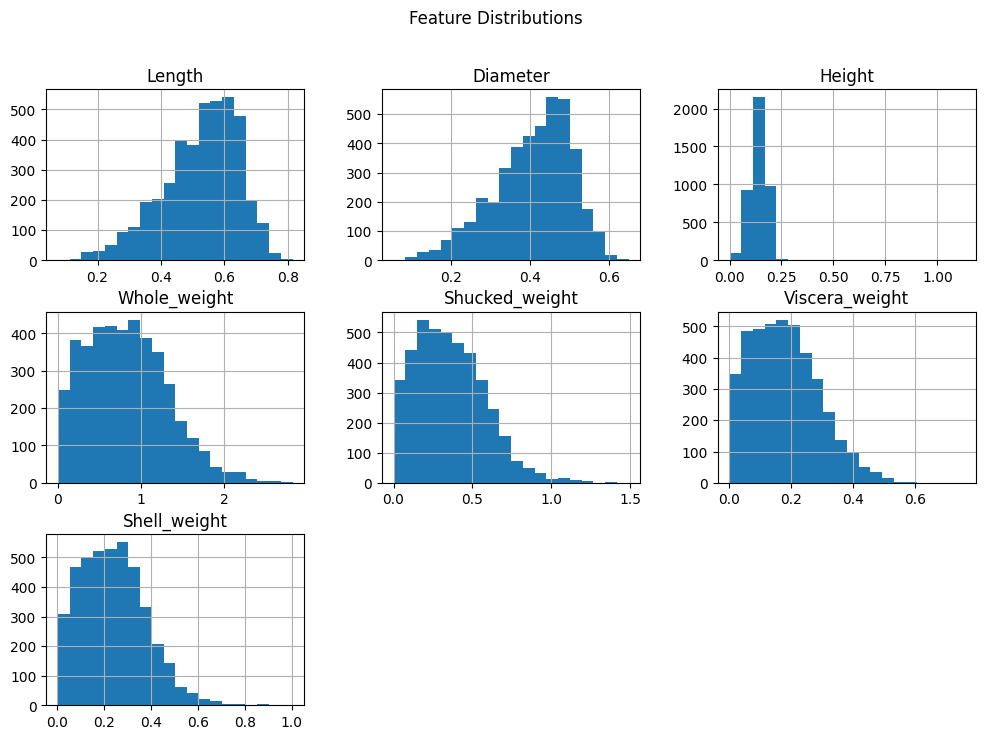

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

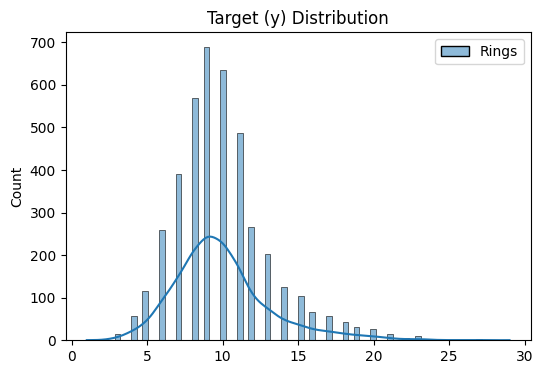

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

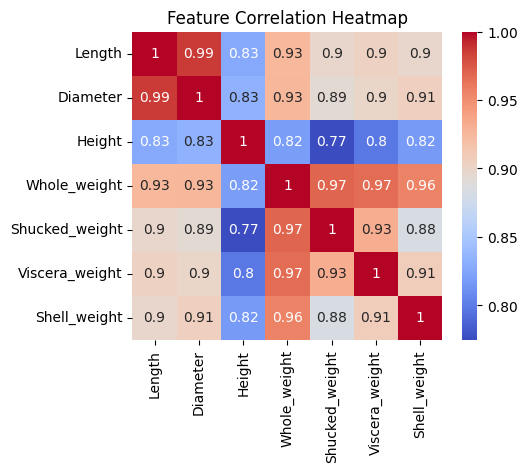

In [7]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
X = X.values.astype(float)
y = np.array(y).astype(np.float32).reshape(-1)

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.027723                 1.106580             1.095129   
1                  1.134738                 1.043770             1.055776   
2                  1.111871                 1.196289             1.139626   
3                  1.109429                 1.066919             1.061519   
4                  1.051324                 1.051077             1.050939   
mean               1.087017                 1.092927             1.080598   
std                0.045241                 0.062679             0.037267   

      DefaultBART_Rhat_RMSE  
0                  1.111169  
1                  1.095891  
2                  1.183276  
3                  1.172759  
4                  1.382032  
mean               1.189025  
std                0.114329  


In [10]:
rhat_df.to_csv("results/real1_Abalone_rhat.csv", index=False)

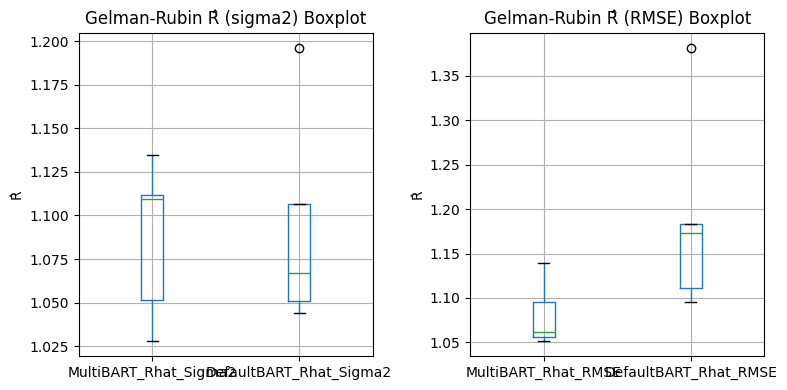

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
      bart_mtmh      bart       btz       sto        rf       xgb
0      4.934722  4.921838  4.903378  4.716110  4.791655  5.722874
1      4.643899  4.782947  4.814521  4.684420  4.574730  5.348410
2      5.356877  5.375859  5.341948  5.310046  5.399027  5.810473
3      4.455256  4.569991  4.516953  4.557791  4.645710  5.385919
4      4.315213  4.429485  4.469932  4.249891  4.558238  5.046336
5      5.266813  5.050998  5.142657  4.916213  5.052298  5.874977
6      5.273650  5.149334  4.866876  4.977305  4.946810  5.660102
7      5.302310  5.275648  5.287504  5.397489  5.139162  5.571136
8      5.086447  4.986300  4.828933  4.892395  4.887725  5.738235
9      5.258776  5.205645  5.243740  5.231934  5.280333  5.807626
mean   4.989396  4.974804  4.941644  4.893359  4.927569  5.596609
std    0.385125  0.305850  0.307377  0.357726  0.292084  0.261880



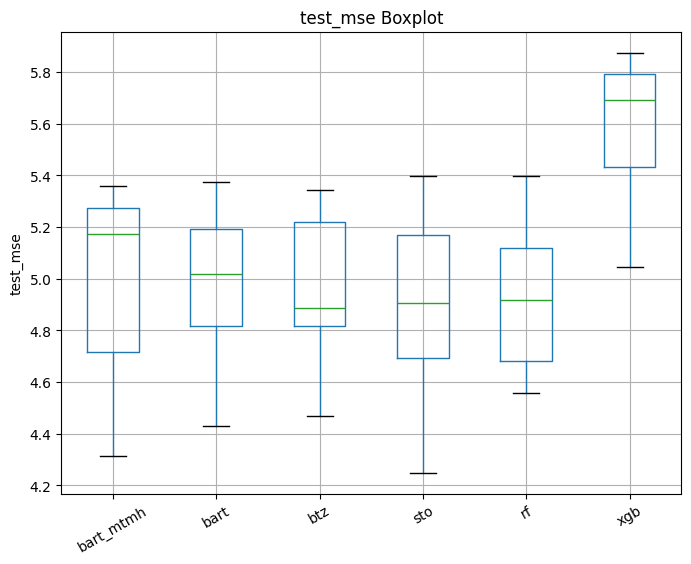

train_mse:
      bart_mtmh      bart       btz       sto        rf       xgb
0      3.353553  3.822420  3.907227  4.328348  0.679427  0.542755
1      3.410069  3.930556  3.998078  4.291799  0.683244  0.606606
2      3.213656  3.677880  3.762385  4.009102  0.639765  0.543232
3      3.336763  3.815158  3.964890  4.309125  0.677036  0.545936
4      3.485579  3.942961  4.066865  4.359262  0.681703  0.621954
5      3.186461  3.706920  3.831447  4.197691  0.647193  0.533894
6      3.192707  3.747453  3.914979  4.130485  0.680122  0.566025
7      3.248499  3.694902  3.772048  4.198400  0.656752  0.540149
8      3.271926  3.781683  3.909686  4.260820  0.674107  0.535856
9      3.130564  3.650783  3.734415  4.149320  0.667631  0.549909
mean   3.282978  3.777071  3.886202  4.223435  0.668698  0.558632
std    0.111497  0.101622  0.109325  0.107616  0.015522  0.030849



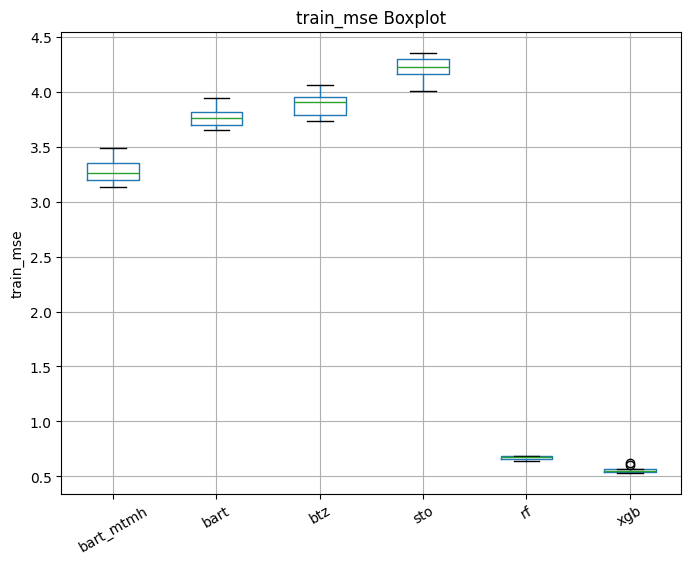

pi_length:
      bart_mtmh      bart       btz        sto
0      7.996600  8.111489  8.321729  18.416809
1      8.054620  8.145915  8.310478  18.580148
2      7.917384  7.958013  8.180437  17.756464
3      8.007494  8.135096  8.282703  18.327466
4      8.228729  8.293824  8.423567  18.844739
5      7.770860  7.982258  8.273747  19.106047
6      7.805506  8.028399  8.287833  18.674295
7      7.874495  8.003766  8.244265  17.303595
8      7.918515  8.049076  8.317192  18.326821
9      7.878866  7.970416  8.137183  18.073429
mean   7.945307  8.067825  8.277913  18.340981
std    0.133199  0.104607  0.079103   0.527357



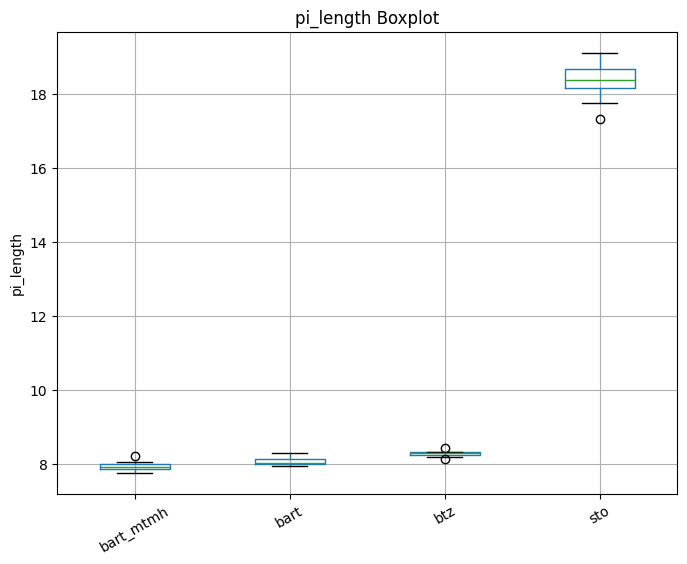

coverage:
      bart_mtmh      bart       btz       sto
0      0.934928  0.936842  0.942584  0.980861
1      0.930144  0.929187  0.933971  0.984689
2      0.926316  0.925359  0.922488  0.977990
3      0.941627  0.933971  0.941627  0.979904
4      0.943541  0.938756  0.941627  0.985646
5      0.919617  0.925359  0.931100  0.981818
6      0.906220  0.913876  0.933014  0.972249
7      0.918660  0.916746  0.922488  0.977990
8      0.927273  0.936842  0.936842  0.971292
9      0.923445  0.929187  0.926316  0.976077
mean   0.927177  0.928612  0.933206  0.978852
std    0.011200  0.008478  0.007640  0.004762



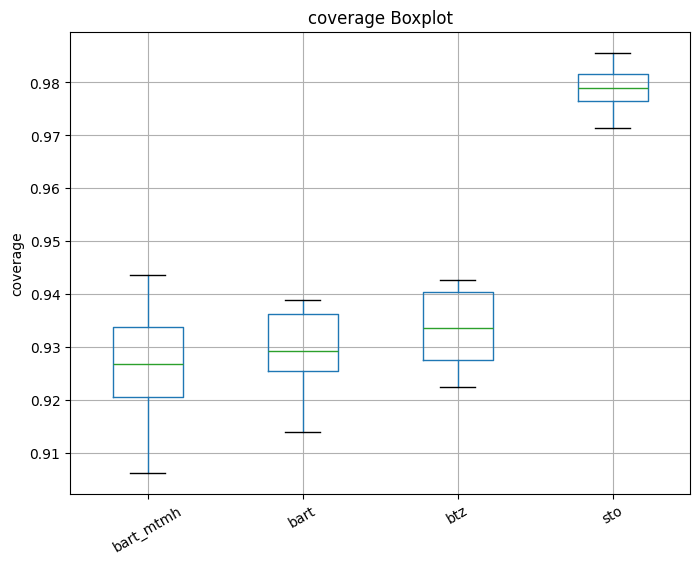

train_time:
       bart_mtmh       bart        btz        sto        rf       xgb
0     171.898347  19.831020  31.515403  36.715407  1.499311  0.161642
1     172.682958  19.987087  32.557793  36.053267  1.486416  0.135442
2     175.320317  21.391109  37.931824  34.161790  1.444073  0.164073
3     173.346179  20.028938  33.894718  35.586530  1.533697  0.140747
4     172.651507  19.758417  32.242953  36.373431  1.479982  0.115991
5     178.848999  20.247754  27.005135  37.448468  1.486609  0.050863
6     177.141065  19.934415  25.738722  38.026140  1.502564  0.056148
7     178.649389  20.228571  27.379171  37.449315  1.502155  0.060915
8     177.626331  21.500939  28.209302  36.758984  1.470858  0.054914
9     180.340470  40.915987  16.956755  33.455569  1.303490  0.046527
mean  175.850556  22.382424  29.343178  36.202890  1.470916  0.098726
std     3.059463   6.541432   5.724872   1.458554  0.063286  0.049237



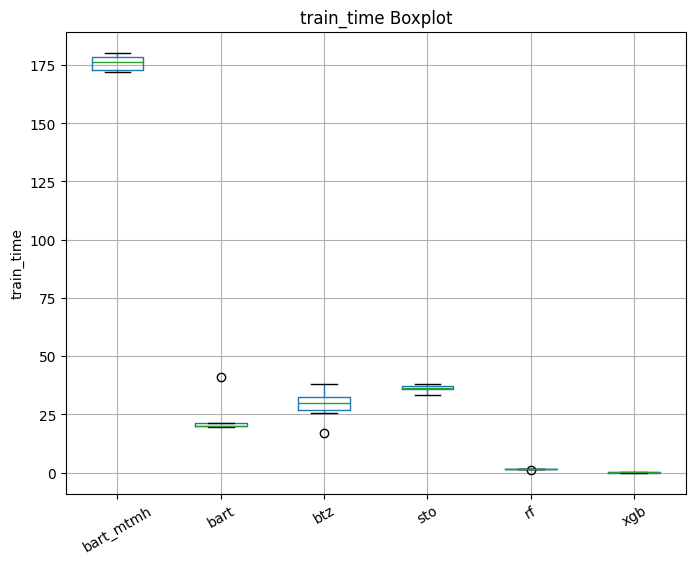

In [9]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [10]:
for k, v in mse_results.items():
    csv_name = f"results/real1_Abalone_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real1_Abalone_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50, 100],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real1_Abalone_tries.csv", index=False)

In [13]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage   Train_Time
0            1     1.049227   1.312639  4.768989  0.934928    34.806536
1            5     1.075557   1.129726  4.716895  0.937416   115.323896
2           10     1.087017   1.080598  4.754522  0.934545   207.882198
3           50     1.050677   1.077421  4.847060  0.932249   934.421411
4          100     1.148539   1.097302  4.908712  0.931866  1960.306097
